In [1]:
%matplotlib notebook
import os
import sys
import numpy as np
#from get_dataset import get_scan, scan_pading, save_seg_imgs
from tensorflow.keras.models import model_from_json, load_model
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.io import loadmat

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
def get_outline(data):
    if(data.ndim!=4):
        print('need to be a 4 dimension bool matrix!')
        return
    contour = np.zeros(data.shape)
    for i in range(0,data.shape[3]):
        for row in range(data.shape[1]):
            for col in range(data.shape[2]):
                if(data[0][row][col][i]==True and (col==0 or data[0][row][col-1][i]==False)):
                    contour[0][row][col][i] = i+1
                if(data[0][row][col][i]==True and (col==data.shape[2]-1 or data[0][row][col+1][i]==False)):
                    contour[0][row][col][i] = i+1
    
    for i in range(0,data.shape[3]):
        for col in range(data.shape[2]):
            for row in range(data.shape[1]):
                if(data[0][row][col][i]==True and (row==0 or data[0][row-1][col][i]==False)):
                    contour[0][row][col][i] = i+1
                if(data[0][row][col][i]==True and (col==data.shape[1]-1 or data[0][row+1][col][i]==False)):
                    contour[0][row][col][i] = i+1
    return contour

In [4]:
class IndexTracker(object):
    def __init__(self, ax, X,fig,bmin,bmax):
        self.ax = ax
        ax.set_title('use scroll wheel to navigate images')

        self.X = X
        self.fig = fig
        self.slices, row, cols = X.shape
        self.ind = self.slices//2

        self.im = ax.imshow(self.X[self.ind,:,:],cmap='jet',vmin=bmin, vmax=bmax)
        fig.colorbar(self.im, ax=self.ax )
      #  self.im.colorbar()
        self.update()

    def onscroll(self, event):
        print("%s %s" % (event.button, event.step))
        if event.button == 'up':
            self.ind = (self.ind + 1) % self.slices
        else:
            self.ind = (self.ind - 1) % self.slices
        self.update()

    def update(self):
        self.im.set_data(self.X[self.ind,:, :])
        self.ax.set_ylabel('slice %s' % self.ind)
        self.im.axes.figure.canvas.draw()

In [5]:
def mse(imageA, imageB):
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1]*imageA.shape[2]*imageA.shape[3])

    # return the MSE, the lower the error, the more "similar"
    # the two images are
    return err

In [6]:
def compare_dose(model, test_path, patient, save_dose,save_path): 
    # compare the dose distribution 
    file_path= test_path + 'data_'+patient+'_NEW.mat'
    f = loadmat(file_path)
    # read the true structure and dose for test patient
    structure = f['structset_2d_channel']
    dose_true = f['doseset_2d']
    dose_true = np.expand_dims(dose_true,axis=3)
    structure = np.array(structure, dtype='float32')
    dose_true = np.array(dose_true).astype('float32')
    
    # crop the true dose outside body
    mask = structure>0
    mask_Body = np.squeeze(mask[:,:,:,0])
    mask_Body = np.expand_dims(mask_Body,axis=3)
    dose_true = np.multiply(dose_true, mask_Body)
    print('structure and dose loaded for patient', patient)
    
    # start to get the dose predict and crop it inside the body structure
    dose_predict = np.zeros(dose_true.shape)
    dose_diff = np.zeros(dose_true.shape)
    for i in range(0,dose_true.shape[0]):
        structure_plane = np.expand_dims(structure[i,:,:,:],axis=0)
        dose_plane = model.predict(structure_plane)
        dose_predict[i,:,:,:]=dose_plane
    dose_predict = np.multiply(dose_predict, mask_Body)
    if(save_dose==True):
         np.save(save_path, dose_predict)
        
    # get lung mask
    mask_Lung = np.squeeze(mask[:,:,:,7])
    mask_Lung = mask_Lung.flatten()
    # get predicted lung dose (flattened)
    dose_flat = dose_predict.flatten()
    dose_masked =  np.ma.masked_where(mask_Lung==False, dose_flat)
    dose_Lung_predict = dose_masked.compressed()
    
    # get true dose lung dose and normalize it to mean 8Gy 
    dose_flat = dose_true.flatten()
    dose_masked =  np.ma.masked_where(mask_Lung==False, dose_flat)
    dose_Lung_true = dose_masked.compressed()
    max_dose=dose_flat.max()
    dose_true = dose_true/dose_Lung_true.mean()*8.0 # normalize the true dose to lung Dmean=8Gy
    
    # get dose diff between predict dose and normalized true dose
    dose_diff = np.add(np.multiply(-1,dose_true),dose_predict)
    
    # display the mask_organ to display for senity check 
    organ = 7
    mask_organ = np.squeeze(mask[:,:,:,organ])
    mask_organ = np.array(mask_organ).astype('float32')
    
    # figure plot
    fig, (ax1, ax2, ax3, ax4)= plt.subplots(4, 1)
    tracker1 = IndexTracker(ax1, np.squeeze(dose_true), fig,0,30)
    fig.canvas.mpl_connect('scroll_event', tracker1.onscroll)
    tracker2 = IndexTracker(ax2, np.squeeze(dose_predict), fig,0,30)
    fig.canvas.mpl_connect('scroll_event', tracker2.onscroll)
    tracker3 = IndexTracker(ax3, np.squeeze(dose_diff), fig,dose_diff.min(),dose_diff.max())
    fig.canvas.mpl_connect('scroll_event', tracker3.onscroll)
    tracker4 = IndexTracker(ax4, mask_organ, fig,0,1)
    fig.canvas.mpl_connect('scroll_event', tracker4.onscroll)
    plt.show()      
    

In [7]:
def compare_DVH(model, test_path, patient, organ_index, organ_name,normalize = True):
    file_path= test_path + 'data_'+patient+'_NEW.mat'
    f = loadmat(file_path)
    # get the true dose
    structure = f['structset_2d_channel']
    dose_true = f['doseset_2d']
    dose_true = np.expand_dims(dose_true,axis=3)
    structure = np.array(structure, dtype='float32')
    dose_true = np.array(dose_true).astype('float32')
    
    # get the body mask and Lung mask 
    mask = structure>0
    mask_Body = np.squeeze(mask[:,:,:,0])
    mask_Body = np.expand_dims(mask_Body,axis=3)
    #dose_true = np.multiply(dose_true, mask_Body)
    mask_Lung = np.squeeze(mask[:,:,:,7])
    
    # get the predict dose and dose difference between true dose(un-normlized) and predict dose
    dose_predict = np.zeros(dose_true.shape)
    dose_diff = np.zeros(dose_true.shape)
    for i in range(0,dose_true.shape[0]):
        structure_plane = np.expand_dims(structure[i,:,:,:],axis=0)
        dose_plane = model.predict(structure_plane)
        dose_predict[i,:,:,:]=dose_plane
    dose_diff = np.add(np.multiply(-1,dose_true),dose_predict)
    print("the MSE before dose normalization to lung is", mse(dose_true, dose_predict))
    
    # if we want to compare the dose with normalized true dose
    if (normalize == True):
        mask_Lung = mask_Lung.flatten()
        dose_flat = dose_true.flatten()
        dose_masked =  np.ma.masked_where(mask_Lung==False, dose_flat)
        dose_true_Lung = dose_masked.compressed()
        dose_true = dose_true/dose_true_Lung.mean()*8.0
        print("the MSE after dose normalization to lung is", mse(dose_true, dose_predict))
    
    ## Definie some dosimetric evaluation - Dmean, Dmax, D98, D5...
    organ_number = len(organ_index)
    organ_true_mean = np.zeros(organ_number)
    organ_true_max = np.zeros(organ_number)
    D95_true = np.zeros(organ_number)
    D5_true = np.zeros(organ_number)
    D98_true = np.zeros(organ_number)
    D2_true = np.zeros(organ_number)
    organ_predict_mean = np.zeros(organ_number)
    organ_predict_max = np.zeros(organ_number)
    D95_predict = np.zeros(organ_number)
    D5_predict = np.zeros(organ_number)
    D98_predict = np.zeros(organ_number)
    D2_predict = np.zeros(organ_number)
    
    ## Define DVH bin and range
    DVH_inv = 0.05
    DVH_bin = int(29/DVH_inv+30)
    DVH_true_all = np.zeros([organ_number,DVH_bin])
    DVH_predict_all = np.zeros([organ_number,DVH_bin])
    dose_bin = np.zeros(DVH_bin)
    dose_bin = np.arange(0,DVH_bin)*DVH_inv
    dose_bin1 = np.arange(-1,DVH_bin)*DVH_inv
    
    ## Go over each organ to extract the DVH and other dosimetric information
    dose_flat = dose_true.flatten()
    dose_flat_predict = dose_predict.flatten()
    mask = structure>0
    for organ in organ_index:
        # generate the mask for specific organ
        mask_organ = np.squeeze(mask[:,:,:,organ])
        mask_organ = mask_organ.flatten()
        volume = len(mask_organ==True)
        
        # make the dose_true organ as dose_organ
        dose_masked =  np.ma.masked_where(mask_organ==False, dose_flat)
        dose_organ = dose_masked.compressed()
        organ_true_mean[organ-1] = dose_organ.mean()
        organ_true_max[organ-1] = dose_organ.max()
        
        # make the dose_predict organ as "dose"
        dose_masked =  np.ma.masked_where(mask_organ==False, dose_flat_predict)
        dose_organ_predict = dose_masked.compressed()
        organ_predict_mean[organ-1] = dose_organ_predict.mean()
        organ_predict_max[organ-1] = dose_organ_predict.max()
    
        DVH_true = np.zeros(DVH_bin)
        DVH_predict = np.zeros(DVH_bin)
    
        DVH, bin_edges = np.histogram(dose_organ,dose_bin1)
        DVH_true = np.cumsum(DVH)
        DVH_true = 1 - DVH_true/DVH_true.max()
    
        DVH, bin_edges =  np.histogram(dose_organ_predict,dose_bin1)
        DVH_predict = np.cumsum(DVH)
        DVH_predict = 1-DVH_predict/DVH_predict.max()
    
        index = np.argmin(np.abs(DVH_true-0.95))
        D95_true[organ-1] = index*DVH_inv
        index = np.argmin(np.abs(DVH_predict-0.95))
        D95_predict[organ-1] = index*DVH_inv
    
        index = np.argmin(np.abs(DVH_true-0.98))
        D98_true[organ-1] = index*DVH_inv
        index = np.argmin(np.abs(DVH_predict-0.98))
        D98_predict[organ-1] = index*DVH_inv
    
        index = np.argmin(np.abs(DVH_true-0.05))
        D5_true[organ-1] = index*DVH_inv
        index = np.argmin(np.abs(DVH_predict-0.05))
        D5_predict[organ-1] = index*DVH_inv
    
        index = np.argmin(np.abs(DVH_true-0.02))
        D2_true[organ-1] = index*DVH_inv
        index = np.argmin(np.abs(DVH_predict-0.02))
        D2_predict[organ-1] = index*DVH_inv
        
        DVH_true_all[organ-1,:] = DVH_true
        DVH_predict_all[organ-1,:]=DVH_predict
    
        DVH_true_all[organ-1,:] = DVH_true
        DVH_predict_all[organ-1,:] = DVH_predict

        print(organ_name[organ])
        print('True mean organ dose is: ', dose_organ.mean())
        print('Predict mean organ dose is: ', dose_organ_predict.mean())
        print('the dose difference is:', '{:.2%}'.format((dose_organ_predict.mean()-dose_organ.mean())/20))
        print('True max organ dose is: ', dose_organ.max())
        print('Predict max organ dose is: ', dose_organ_predict.max())
        print('the dose difference is:', '{:.2%}'.format((dose_organ_predict.max()-dose_organ.max())/20))
    fig = plt.figure()
    plt.plot(dose_bin,DVH_true_all[0,:]*100, color='skyblue', linewidth=1)
    plt.plot(dose_bin,DVH_true_all[1,:]*100, color='b', linewidth=1)
    plt.plot(dose_bin,DVH_true_all[2,:]*100, color='g', linewidth=1)
    plt.plot(dose_bin,DVH_true_all[3,:]*100, color='r', linewidth=1)
    plt.plot(dose_bin,DVH_true_all[4,:]*100, color='c', linewidth=1)
    plt.plot(dose_bin,DVH_true_all[5,:]*100, color='m', linewidth=1)
    plt.plot(dose_bin,DVH_true_all[6,:]*100, color='chocolate', linewidth=1)
    plt.plot(dose_bin,DVH_true_all[7,:]*100, color='y', linewidth=1)
    plt.plot(dose_bin,DVH_true_all[8,:]*100, color='k', linewidth=1)
    plt.plot(dose_bin,DVH_true_all[9,:]*100, color='gold', linewidth=1)

    plt.plot(dose_bin,DVH_predict_all[0,:]*100, color='skyblue', linewidth=1, linestyle='dashed')
    plt.plot(dose_bin,DVH_predict_all[1,:]*100, color='b', linewidth=1, linestyle='dashed')
    plt.plot(dose_bin,DVH_predict_all[2,:]*100, color='g', linewidth=1, linestyle='dashed')
    plt.plot(dose_bin,DVH_predict_all[3,:]*100, color='r', linewidth=1, linestyle='dashed')
    plt.plot(dose_bin,DVH_predict_all[4,:]*100, color='c', linewidth=1, linestyle='dashed')
    plt.plot(dose_bin,DVH_predict_all[5,:]*100, color='m', linewidth=1, linestyle='dashed')
    plt.plot(dose_bin,DVH_predict_all[6,:]*100, color='chocolate', linewidth=1,linestyle='dashed')
    plt.plot(dose_bin,DVH_predict_all[7,:]*100, color='y', linewidth=1, linestyle='dashed')
    plt.plot(dose_bin,DVH_predict_all[8,:]*100, color='k', linewidth=1, linestyle='dashed')
    plt.plot(dose_bin,DVH_predict_all[9,:]*100, color='gold', linewidth=1, linestyle='dashed')

    plt.ylabel('volume %')
    plt.legend(['PTV_Ribs','PTV_VExP','PTV_SpinalCord','PTV_LN','PTV_Spleen','PTV_Liver','Lungs','Heart','Esophagus','GI_Upper'], loc='upper right',bbox_to_anchor=(1.1, 1.05),prop={'size': 6}) 
    plt.show()
    return organ_true_mean, organ_true_max, D95_true, D5_true, D98_true, D2_true, organ_predict_mean, organ_predict_max, D95_predict,D5_predict, D98_predict, D2_predict

In [8]:
def compare_dose2(model, test_path, step2_feature_file, patient, save_dose,save_path): 
    # compare the dose distribution 
    file_path= test_path + 'data_'+patient+'_NEW.mat'
    f = loadmat(file_path)
    # read the true structure and dose for test patient
  #  structure = f['structset_2d_channel']
    dose_true = f['doseset_2d']
    dose_true = np.expand_dims(dose_true,axis=3)
    structure = np.load(step2_feature_file)
    dose_true = np.array(dose_true).astype('float32')
    
    # crop the true dose outside body
    mask = structure>0
    mask_Body = np.squeeze(mask[:,:,:,0])
    mask_Body = np.expand_dims(mask_Body,axis=3)
    dose_true = np.multiply(dose_true, mask_Body)
    print('structure and dose loaded for patient', patient)
    
    # start to get the dose predict and crop it inside the body structure
    dose_predict = np.zeros(dose_true.shape)
    dose_diff = np.zeros(dose_true.shape)
    for i in range(0,dose_true.shape[0]):
        structure_plane = np.expand_dims(structure[i,:,:,:],axis=0)
        dose_plane = model.predict(structure_plane)
        dose_predict[i,:,:,:]=dose_plane
    dose_predict = np.multiply(dose_predict, mask_Body)
    if(save_dose==True):
         np.save(save_path, dose_predict)
        
    # get lung mask
    mask_Lung = np.squeeze(mask[:,:,:,7])
    mask_Lung = mask_Lung.flatten()
    # get predicted lung dose (flattened)
    dose_flat = dose_predict.flatten()
    dose_masked =  np.ma.masked_where(mask_Lung==False, dose_flat)
    dose_Lung_predict = dose_masked.compressed()
    
    # get true dose lung dose and normalize it to mean 8Gy 
    dose_flat = dose_true.flatten()
    dose_masked =  np.ma.masked_where(mask_Lung==False, dose_flat)
    dose_Lung_true = dose_masked.compressed()
    max_dose=dose_flat.max()
    dose_true = dose_true/dose_Lung_true.mean()*8.0 # normalize the true dose to lung Dmean=8Gy
    
    # get dose diff between predict dose and normalized true dose
    dose_diff = np.add(np.multiply(-1,dose_true),dose_predict)
    
    # display the mask_organ to display for senity check 
    organ = 7
    mask_organ = np.squeeze(mask[:,:,:,organ])
    mask_organ = np.array(mask_organ).astype('float32')
    
    # figure plot
    fig, (ax1, ax2, ax3, ax4)= plt.subplots(4, 1)
    tracker1 = IndexTracker(ax1, np.squeeze(dose_true), fig,0,30)
    fig.canvas.mpl_connect('scroll_event', tracker1.onscroll)
    tracker2 = IndexTracker(ax2, np.squeeze(dose_predict), fig,0,30)
    fig.canvas.mpl_connect('scroll_event', tracker2.onscroll)
    tracker3 = IndexTracker(ax3, np.squeeze(dose_diff), fig,dose_diff.min(),dose_diff.max())
    fig.canvas.mpl_connect('scroll_event', tracker3.onscroll)
    tracker4 = IndexTracker(ax4, mask_organ, fig,0,1)
    fig.canvas.mpl_connect('scroll_event', tracker4.onscroll)
    plt.show()      
    

In [10]:
def compare_DVH2(model, test_path, step2_feature_file,patient, organ_index, organ_name,normalize = True):
    file_path= test_path + 'data_'+patient+'_NEW.mat'
    f = loadmat(file_path)
    # get the true dose
   # structure = f['structset_2d_channel']
    dose_true = f['doseset_2d']
    dose_true = np.expand_dims(dose_true,axis=3)
    structure = np.load(step2_feature_file)
    dose_true = np.array(dose_true).astype('float32')
    
    # get the body mask and Lung mask 
    mask = structure>0
    mask_Body = np.squeeze(mask[:,:,:,0])
    mask_Body = np.expand_dims(mask_Body,axis=3)
    #dose_true = np.multiply(dose_true, mask_Body)
    mask_Lung = np.squeeze(mask[:,:,:,7])
    
    # get the predict dose and dose difference between true dose(un-normlized) and predict dose
    dose_predict = np.zeros(dose_true.shape)
    dose_diff = np.zeros(dose_true.shape)
    for i in range(0,dose_true.shape[0]):
        structure_plane = np.expand_dims(structure[i,:,:,:],axis=0)
        dose_plane = model.predict(structure_plane)
        dose_predict[i,:,:,:]=dose_plane
    dose_diff = np.add(np.multiply(-1,dose_true),dose_predict)
    print("the MSE before dose normalization to lung is", mse(dose_true, dose_predict))
    
    # if we want to compare the dose with normalized true dose
    if (normalize == True):
        mask_Lung = mask_Lung.flatten()
        dose_flat = dose_true.flatten()
        dose_masked =  np.ma.masked_where(mask_Lung==False, dose_flat)
        dose_true_Lung = dose_masked.compressed()
        dose_true = dose_true/dose_true_Lung.mean()*8.0
        print("the MSE after dose normalization to lung is", mse(dose_true, dose_predict))
    
    ## Definie some dosimetric evaluation - Dmean, Dmax, D98, D5...
    organ_number = len(organ_index)
    organ_true_mean = np.zeros(organ_number)
    organ_true_max = np.zeros(organ_number)
    D95_true = np.zeros(organ_number)
    D5_true = np.zeros(organ_number)
    D98_true = np.zeros(organ_number)
    D2_true = np.zeros(organ_number)
    organ_predict_mean = np.zeros(organ_number)
    organ_predict_max = np.zeros(organ_number)
    D95_predict = np.zeros(organ_number)
    D5_predict = np.zeros(organ_number)
    D98_predict = np.zeros(organ_number)
    D2_predict = np.zeros(organ_number)
    
    ## Define DVH bin and range
    DVH_inv = 0.05
    DVH_bin = int(29/DVH_inv+30)
    DVH_true_all = np.zeros([organ_number,DVH_bin])
    DVH_predict_all = np.zeros([organ_number,DVH_bin])
    dose_bin = np.zeros(DVH_bin)
    dose_bin = np.arange(0,DVH_bin)*DVH_inv
    dose_bin1 = np.arange(-1,DVH_bin)*DVH_inv
    
    ## Go over each organ to extract the DVH and other dosimetric information
    dose_flat = dose_true.flatten()
    dose_flat_predict = dose_predict.flatten()
    mask = structure>0
    for organ in organ_index:
        # generate the mask for specific organ
        mask_organ = np.squeeze(mask[:,:,:,organ])
        mask_organ = mask_organ.flatten()
        volume = len(mask_organ==True)
        
        # make the dose_true organ as dose_organ
        dose_masked =  np.ma.masked_where(mask_organ==False, dose_flat)
        dose_organ = dose_masked.compressed()
        organ_true_mean[organ-1] = dose_organ.mean()
        organ_true_max[organ-1] = dose_organ.max()
        
        # make the dose_predict organ as "dose"
        dose_masked =  np.ma.masked_where(mask_organ==False, dose_flat_predict)
        dose_organ_predict = dose_masked.compressed()
        organ_predict_mean[organ-1] = dose_organ_predict.mean()
        organ_predict_max[organ-1] = dose_organ_predict.max()
    
        DVH_true = np.zeros(DVH_bin)
        DVH_predict = np.zeros(DVH_bin)
    
        DVH, bin_edges = np.histogram(dose_organ,dose_bin1)
        DVH_true = np.cumsum(DVH)
        DVH_true = 1 - DVH_true/DVH_true.max()
    
        DVH, bin_edges =  np.histogram(dose_organ_predict,dose_bin1)
        DVH_predict = np.cumsum(DVH)
        DVH_predict = 1-DVH_predict/DVH_predict.max()
    
        index = np.argmin(np.abs(DVH_true-0.95))
        D95_true[organ-1] = index*DVH_inv
        index = np.argmin(np.abs(DVH_predict-0.95))
        D95_predict[organ-1] = index*DVH_inv
    
        index = np.argmin(np.abs(DVH_true-0.98))
        D98_true[organ-1] = index*DVH_inv
        index = np.argmin(np.abs(DVH_predict-0.98))
        D98_predict[organ-1] = index*DVH_inv
    
        index = np.argmin(np.abs(DVH_true-0.05))
        D5_true[organ-1] = index*DVH_inv
        index = np.argmin(np.abs(DVH_predict-0.05))
        D5_predict[organ-1] = index*DVH_inv
    
        index = np.argmin(np.abs(DVH_true-0.02))
        D2_true[organ-1] = index*DVH_inv
        index = np.argmin(np.abs(DVH_predict-0.02))
        D2_predict[organ-1] = index*DVH_inv
        
        DVH_true_all[organ-1,:] = DVH_true
        DVH_predict_all[organ-1,:]=DVH_predict
    
        DVH_true_all[organ-1,:] = DVH_true
        DVH_predict_all[organ-1,:] = DVH_predict

        print(organ_name[organ])
        print('True mean organ dose is: ', dose_organ.mean())
        print('Predict mean organ dose is: ', dose_organ_predict.mean())
        print('the dose difference is:', '{:.2%}'.format((dose_organ_predict.mean()-dose_organ.mean())/20))
        print('True max organ dose is: ', dose_organ.max())
        print('Predict max organ dose is: ', dose_organ_predict.max())
        print('the dose difference is:', '{:.2%}'.format((dose_organ_predict.max()-dose_organ.max())/20))
    fig = plt.figure()
    plt.plot(dose_bin,DVH_true_all[0,:]*100, color='skyblue', linewidth=1)
    plt.plot(dose_bin,DVH_true_all[1,:]*100, color='b', linewidth=1)
    plt.plot(dose_bin,DVH_true_all[2,:]*100, color='g', linewidth=1)
    plt.plot(dose_bin,DVH_true_all[3,:]*100, color='r', linewidth=1)
    plt.plot(dose_bin,DVH_true_all[4,:]*100, color='c', linewidth=1)
    plt.plot(dose_bin,DVH_true_all[5,:]*100, color='m', linewidth=1)
    plt.plot(dose_bin,DVH_true_all[6,:]*100, color='chocolate', linewidth=1)
    plt.plot(dose_bin,DVH_true_all[7,:]*100, color='y', linewidth=1)
    plt.plot(dose_bin,DVH_true_all[8,:]*100, color='k', linewidth=1)
    plt.plot(dose_bin,DVH_true_all[9,:]*100, color='gold', linewidth=1)

    plt.plot(dose_bin,DVH_predict_all[0,:]*100, color='skyblue', linewidth=1, linestyle='dashed')
    plt.plot(dose_bin,DVH_predict_all[1,:]*100, color='b', linewidth=1, linestyle='dashed')
    plt.plot(dose_bin,DVH_predict_all[2,:]*100, color='g', linewidth=1, linestyle='dashed')
    plt.plot(dose_bin,DVH_predict_all[3,:]*100, color='r', linewidth=1, linestyle='dashed')
    plt.plot(dose_bin,DVH_predict_all[4,:]*100, color='c', linewidth=1, linestyle='dashed')
    plt.plot(dose_bin,DVH_predict_all[5,:]*100, color='m', linewidth=1, linestyle='dashed')
    plt.plot(dose_bin,DVH_predict_all[6,:]*100, color='chocolate', linewidth=1,linestyle='dashed')
    plt.plot(dose_bin,DVH_predict_all[7,:]*100, color='y', linewidth=1, linestyle='dashed')
    plt.plot(dose_bin,DVH_predict_all[8,:]*100, color='k', linewidth=1, linestyle='dashed')
    plt.plot(dose_bin,DVH_predict_all[9,:]*100, color='gold', linewidth=1, linestyle='dashed')

    plt.ylabel('volume %')
    plt.legend(['PTV_Ribs','PTV_VExP','PTV_SpinalCord','PTV_LN','PTV_Spleen','PTV_Liver','Lungs','Heart','Esophagus','GI_Upper'], loc='upper right',bbox_to_anchor=(1.1, 1.05),prop={'size': 6}) 
    plt.show()
    return organ_true_mean, organ_true_max, D95_true, D5_true, D98_true, D2_true, organ_predict_mean, organ_predict_max, D95_predict,D5_predict, D98_predict, D2_predict

In [24]:
def main(save_result = False, step2_finish = False):
    
    ## Predict the dose after step 1 optimzaiton
    model =  load_model('Data_v4/Model_UnetDense/model.h5')
    model.load_weights('Data_v4/Model_UnetDense/best_weights.h5')
    patient = 'Colon'
    test_path = 'Data_v4/test/'
    save_path = test_path+patient+'_predict_step1.npy'
    compare_dose(model, test_path, patient,True, save_path)
    # define the organ that we want to compare dose on organ_index
    organ_index = [1,2,3,4,5,6,7,8,9,10]
    organ_name = ['Body', 'PTV_Ribs','PTV_VExP','PTV_SpinalCord','PTV_LN','PTV_Spleen','PTV_Liver','Lungs','Heart','Esophagus','GI_Upper','Breasts','Avoid1']
    compare_DVH(model, test_path, patient, organ_index, organ_name)
    
    # Predict the dose after step2
    if(step2_finish == True):
        save_path_step2=test_path+patient+'step2.npy'
        model =  load_model('Data_v4/Model_UnetDense/step2/step2_model.h5')
        model.load_weights('Data_v4/Model_UnetDense/step2/best_weights.h5')
        step2_feature_file = test_path+patient+'_feature_step2.npy'
        
        compare_dose2(model, test_path, step2_feature_file, patient, True, save_path_step2)
        organ_index = [1,2,3,4,5,6,7,8,9,10]
        organ_name = ['Body', 'PTV_Ribs','PTV_VExP','PTV_SpinalCord','PTV_LN','PTV_Spleen','PTV_Liver','Lungs','Heart','Esophagus','GI_Upper','Breasts','Avoid1']
        compare_DVH2(model, test_path, step2_feature_file,patient, organ_index, organ_name,normalize = True)

structure and dose loaded for patient Colon


<IPython.core.display.Javascript object>


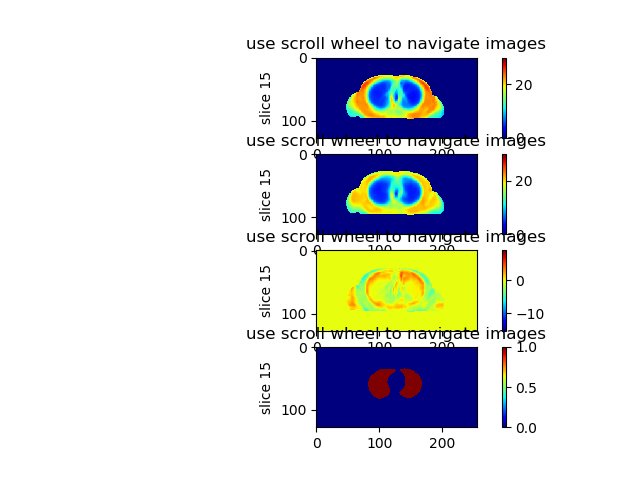

the MSE before dose normalization to lung is 2.623655947867493
the MSE after dose normalization to lung is 3.712563734756906
PTV_Ribs
True mean organ dose is:  19.475191
Predict mean organ dose is:  19.482689726128672
the dose difference is: 0.04%
True max organ dose is:  26.138412
Predict max organ dose is:  23.93623924255371
the dose difference is: -11.01%
PTV_VExP
True mean organ dose is:  21.517363
Predict mean organ dose is:  20.031333042429676
the dose difference is: -7.43%
True max organ dose is:  26.152964
Predict max organ dose is:  23.44280242919922
the dose difference is: -13.55%
PTV_SpinalCord
True mean organ dose is:  21.514381
Predict mean organ dose is:  19.38447853324166
the dose difference is: -10.65%
True max organ dose is:  23.240814
Predict max organ dose is:  21.335445404052734
the dose difference is: -9.53%
PTV_LN
True mean organ dose is:  20.90808
Predict mean organ dose is:  18.86072038245556
the dose difference is: -10.24%
True max organ dose is:  25.685492
Pre

<IPython.core.display.Javascript object>


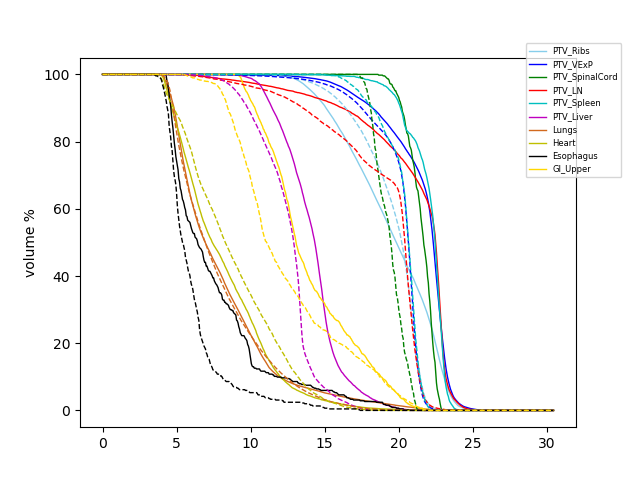

structure and dose loaded for patient Colon


<IPython.core.display.Javascript object>


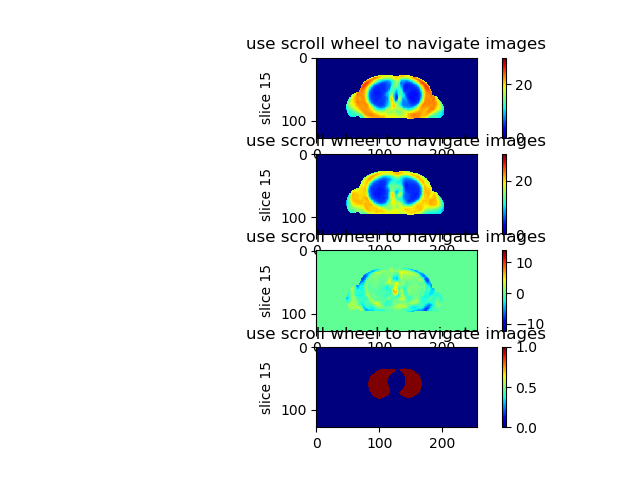

the MSE before dose normalization to lung is 2.4562669651067104
the MSE after dose normalization to lung is 3.4178370436731655
PTV_Ribs
True mean organ dose is:  19.475191
Predict mean organ dose is:  19.380510125776837
the dose difference is: -0.47%
True max organ dose is:  26.138412
Predict max organ dose is:  23.47853660583496
the dose difference is: -13.30%
PTV_VExP
True mean organ dose is:  21.517363
Predict mean organ dose is:  20.35138618527291
the dose difference is: -5.83%
True max organ dose is:  26.152964
Predict max organ dose is:  24.453004837036133
the dose difference is: -8.50%
PTV_SpinalCord
True mean organ dose is:  21.514381
Predict mean organ dose is:  19.88181478403525
the dose difference is: -8.16%
True max organ dose is:  23.240814
Predict max organ dose is:  21.9674072265625
the dose difference is: -6.37%
PTV_LN
True mean organ dose is:  20.90808
Predict mean organ dose is:  20.03870557409883
the dose difference is: -4.35%
True max organ dose is:  25.685492
Predi

<IPython.core.display.Javascript object>


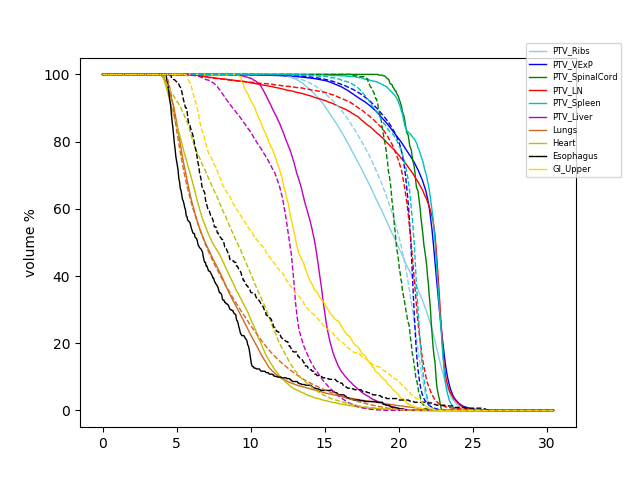

In [25]:
if __name__ == '__main__':
    main(save_result = True, step2_finish = True)

In [ ]:
## important, statistic study after saved all test data


In [2]:
model =  load_model('Data_v3/Checkpoints/GAN-Models/Generator/model.h5')

In [4]:
model =  load_model('Data_v4/Model_UnetDense/model.h5')

In [5]:
model.load_weights('Data_v4/Model_UnetDense/best_weights.h5')

In [6]:
def get_outline(data):
    if(data.ndim!=4):
        print('need to be a 4 dimension bool matrix!')
        return
    contour = np.zeros(data.shape)
    for i in range(0,data.shape[3]):
        for row in range(data.shape[1]):
            for col in range(data.shape[2]):
                if(data[0][row][col][i]==True and (col==0 or data[0][row][col-1][i]==False)):
                    contour[0][row][col][i] = i+1
                if(data[0][row][col][i]==True and (col==data.shape[2]-1 or data[0][row][col+1][i]==False)):
                    contour[0][row][col][i] = i+1
    
    for i in range(0,data.shape[3]):
        for col in range(data.shape[2]):
            for row in range(data.shape[1]):
                if(data[0][row][col][i]==True and (row==0 or data[0][row-1][col][i]==False)):
                    contour[0][row][col][i] = i+1
                if(data[0][row][col][i]==True and (col==data.shape[1]-1 or data[0][row+1][col][i]==False)):
                    contour[0][row][col][i] = i+1
    return contour

In [5]:
training_path='Data_v4/npy_dataset/training_npy_dataset'
train_XY=np.load(training_path+'/batch_105.npy')
X_train, dose=train_XY[:,:,:,0:13],train_XY[:,:,:,13:14]
X_train = np.array(X_train, dtype='bool')
print(X_train.shape)
print(dose.shape)
type(X_train)
contour  = get_outline(X_train)
print(contour.shape)

(1, 128, 256, 13)
(1, 128, 256, 1)
(1, 128, 256, 13)


425984


<IPython.core.display.Javascript object>


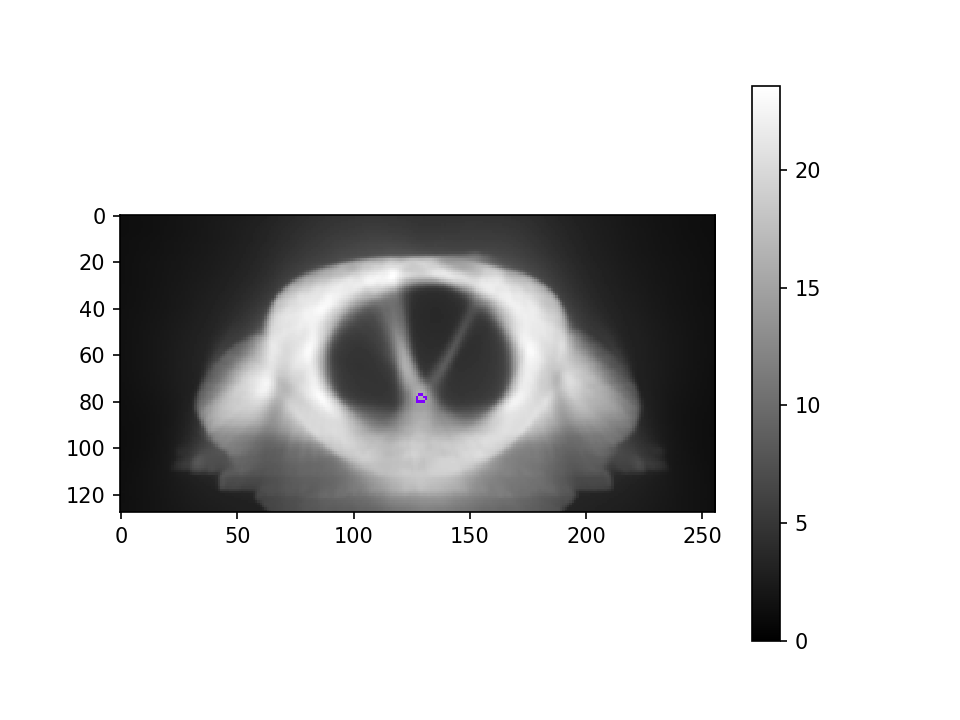

In [6]:
dose_map = np.squeeze(dose)

contour = np.squeeze(contour)
print(contour.size)

plt.imshow(contour[:,:,1], cmap='Blues', alpha=0.3)

plt.imshow(dose_map, cmap='gray')

plt.colorbar()
masked_data = np.ma.masked_where(contour[:,:,6] < 1, contour[:,:,2])
plt.imshow(masked_data, cmap='rainbow')
masked_data = np.ma.masked_where(contour[:,:,3] < 1, contour[:,:,3])
plt.imshow(masked_data, cmap='rainbow')

plt.show()

In [7]:
class IndexTracker(object):
    def __init__(self, ax, X,fig,bmin,bmax):
        self.ax = ax
        ax.set_title('use scroll wheel to navigate images')

        self.X = X
        self.fig = fig
        self.slices, row, cols = X.shape
        self.ind = self.slices//2

        self.im = ax.imshow(self.X[self.ind,:,:],cmap='jet',vmin=bmin, vmax=bmax)
        fig.colorbar(self.im, ax=self.ax )
      #  self.im.colorbar()
        self.update()

    def onscroll(self, event):
        print("%s %s" % (event.button, event.step))
        if event.button == 'up':
            self.ind = (self.ind + 1) % self.slices
        else:
            self.ind = (self.ind - 1) % self.slices
        self.update()

    def update(self):
        self.im.set_data(self.X[self.ind,:, :])
        self.ax.set_ylabel('slice %s' % self.ind)
        self.im.axes.figure.canvas.draw()

structure and dose loaded


<IPython.core.display.Javascript object>


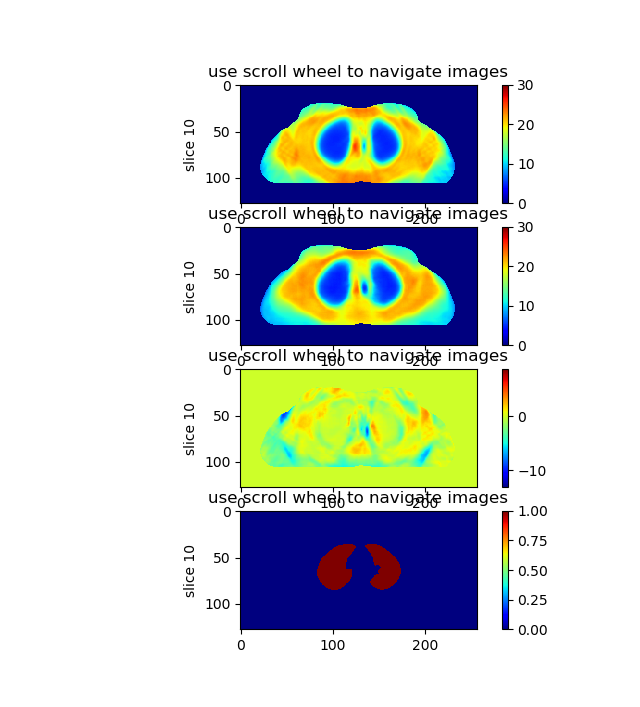

In [8]:
file_path='Data_v4/test/data_LARASH_NEW.mat'
f = loadmat(file_path)
structure = f['structset_2d_channel']
dose_true = f['doseset_2d']
dose_true = np.expand_dims(dose_true,axis=3)
structure = np.array(structure, dtype='float32')
dose_true = np.array(dose_true).astype('float32')

# crop the dose outside body
mask = structure>0
mask_Body = np.squeeze(mask[:,:,:,0])
mask_Body = np.expand_dims(mask_Body,axis=3)
dose_true = np.multiply(dose_true, mask_Body)
print('structure and dose loaded for patient', patient)

# start to get the dose predict
dose_predict = np.zeros(dose_true.shape)
dose_diff = np.zeros(dose_true.shape)
for i in range(0,dose_true.shape[0]):
    structure_plane = np.expand_dims(structure[i,:,:,:],axis=0)
    dose_plane = model.predict(structure_plane)
    dose_predict[i,:,:,:]=dose_plane

dose_predict = np.multiply(dose_predict, mask_Body)


mask_Lung = np.squeeze(mask[:,:,:,7])
mask_Lung = mask_Lung.flatten()
dose_flat = dose_predict.flatten()
dose_masked =  np.ma.masked_where(mask_Lung==False, dose_flat)
dose_Lung_predict = dose_masked.compressed()

#dose_predict = dose_predict/dose_Lung_predict.mean()*8.0

dose_flat = dose_true.flatten()
dose_masked =  np.ma.masked_where(mask_Lung==False, dose_flat)
dose_Lung_true = dose_masked.compressed()

max_dose=dose_flat.max()
dose_true = dose_true/dose_Lung_true.mean()*8.0

### plot organ on figure 4
organ = 7
mask_organ = np.squeeze(mask[:,:,:,organ])
mask_organ = np.array(mask_organ).astype('float32')


dose_diff = np.add(np.multiply(-1,dose_true),dose_predict)
fig, (ax1, ax2, ax3, ax4)= plt.subplots(4, 1)
tracker1 = IndexTracker(ax1, np.squeeze(dose_true), fig,0,30)
fig.canvas.mpl_connect('scroll_event', tracker1.onscroll)
tracker2 = IndexTracker(ax2, np.squeeze(dose_predict), fig,0,30)
fig.canvas.mpl_connect('scroll_event', tracker2.onscroll)
tracker3 = IndexTracker(ax3, np.squeeze(dose_diff), fig,dose_diff.min(),dose_diff.max())
fig.canvas.mpl_connect('scroll_event', tracker3.onscroll)
tracker4 = IndexTracker(ax4, mask_organ, fig,0,1)
fig.canvas.mpl_connect('scroll_event', tracker4.onscroll)

plt.show()                                                    
     

In [9]:
def mse(imageA, imageB):
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1]*imageA.shape[2]*imageA.shape[3])

    # return the MSE, the lower the error, the more "similar"
    # the two images are
    return err

the MSE before dose normalization to lung is 3.3167801663055947
true lung dose mean 7.999999
the MSE after dose normalization to lung is 3.303230857990034
True mean organ dose is:  20.384348
Predict mean organ dose is:  21.885877660040318
the dose difference is: 7.51%
True max organ dose is:  21.499655
Predict max organ dose is:  23.70366096496582
the dose difference is: 11.02%


<IPython.core.display.Javascript object>


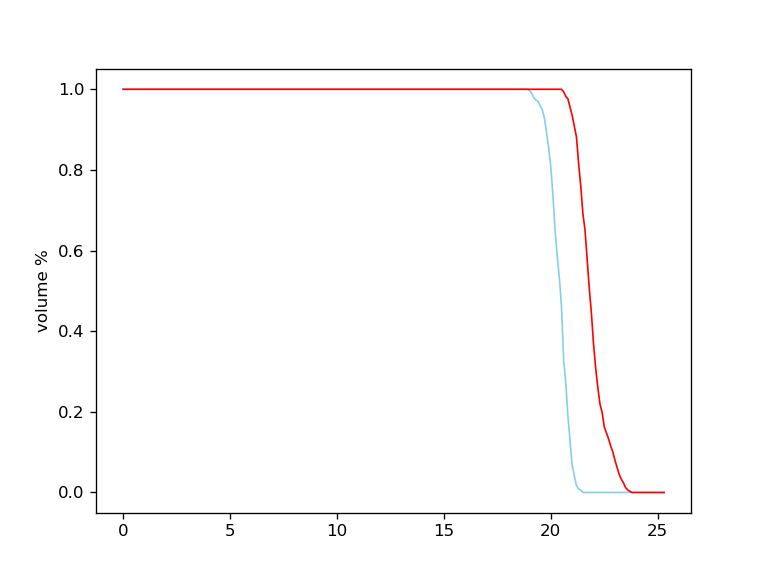

In [47]:
f = loadmat('Data_v4/test/data_PEREZ_NEW.mat')
structure = f['structset_2d_channel']
dose_true = f['doseset_2d']
dose_true = np.expand_dims(dose_true,axis=3)
organ = 3
structure = np.array(structure, dtype='float32')
dose_true = np.array(dose_true).astype('float32')
mask = structure>0
mask_Body = np.squeeze(mask[:,:,:,0])
mask_Body = np.expand_dims(mask_Body,axis=3)
#dose_true = np.multiply(dose_true, mask_Body)
mask_Lung = np.squeeze(mask[:,:,:,7])


dose_predict = np.zeros(dose_true.shape)
dose_diff = np.zeros(dose_true.shape)
for i in range(0,dose_true.shape[0]):
    structure_plane = np.expand_dims(structure[i,:,:,:],axis=0)
    dose_plane = model.predict(structure_plane)
    dose_predict[i,:,:,:]=dose_plane
dose_diff = np.add(np.multiply(-1,dose_true),dose_predict)

print("the MSE before dose normalization to lung is", mse(dose_true, dose_predict))

mask_Lung = mask_Lung.flatten()
dose_flat = dose_true.flatten()
dose_masked =  np.ma.masked_where(mask_Lung==False, dose_flat)
dose_true_Lung = dose_masked.compressed()
dose_true = dose_true/dose_Lung_true.mean()*8.0

dose_flat = dose_true.flatten()
mask_organ = mask_Lung.flatten()
dose_masked =  np.ma.masked_where(mask_organ==False, dose_flat)
dose_organ = dose_masked.compressed()
print('true lung dose mean', dose_organ.mean())


dose_flat = dose_predict.flatten()
dose_masked =  np.ma.masked_where(mask_Lung==False, dose_flat)
dose_predict_Lung = dose_masked.compressed()
#dose_predict = dose_predict/dose_Lung_predict.mean()*8.0

print("the MSE after dose normalization to lung is", mse(dose_true, dose_predict))
      
dose_flat = dose_true.flatten()
dose_flat_predict = dose_predict.flatten()
mask = structure>0
mask_organ = np.squeeze(mask[:,:,:,organ])
mask_organ = mask_organ.flatten()
dose_masked =  np.ma.masked_where(mask_organ==False, dose_flat)
dose_organ = dose_masked.compressed()

dose_masked =  np.ma.masked_where(mask_organ==False, dose_flat_predict)
dose_organ_predict = dose_masked.compressed()
DVH_inv = 0.1
DVH_bin = int(dose_organ.max()/DVH_inv+40)
DVH_true = np.zeros(DVH_bin)
DVH_predict = np.zeros(DVH_bin)
dose_bin = np.zeros(DVH_bin)
print('True mean organ dose is: ', dose_organ.mean())
print('Predict mean organ dose is: ', dose_organ_predict.mean())
print('the dose difference is:', '{:.2%}'.format((dose_organ_predict.mean()-dose_organ.mean())/20))
print('True max organ dose is: ', dose_organ.max())
print('Predict max organ dose is: ', dose_organ_predict.max())
print('the dose difference is:', '{:.2%}'.format((dose_organ_predict.max()-dose_organ.max())/20))

#for i in range(DVH_bin):
#    DVH_true[i] = sum(j > (i*DVH_inv) for j in dose_organ) / len(dose_organ)
#    DVH_predict[i] = sum(j > (i*DVH_inv) for j in dose_organ_predict) / len(dose_organ_predict)
#    dose_bin[i] = DVH_inv*i
dose_bin = np.arange(0,DVH_bin)*DVH_inv
dose_bin1 = np.arange(-1,DVH_bin)*DVH_inv
DVH, bin_edges = np.histogram(dose_organ,dose_bin1)
DVH_true = np.cumsum(DVH)
DVH_true = 1 - DVH_true/DVH_true.max()
DVH, bin_edges =  np.histogram(dose_organ_predict,dose_bin1)
DVH_predict = np.cumsum(DVH)
DVH_predict = 1-DVH_predict/DVH_predict.max()
    
fig = plt.figure()
plt.plot(dose_bin,DVH_true, color='skyblue', linewidth=1)
plt.plot(dose_bin,DVH_predict, color='red', linewidth=1)
plt.ylabel('volume %')
plt.show()

In [10]:
Dmean_true_all = np.zeros((5,10))
Dmean_predict_all = np.zeros((5,10))
Dmean_diff_all = np.zeros((5,10))

Dmax_true_all = np.zeros((5,10))
Dmax_predict_all = np.zeros((5,10))
Dmax_diff_all = np.zeros((5,10))

D95_true_all = np.zeros((5,10))
D95_predict_all = np.zeros((5,10))
D95_diff_all = np.zeros((5,10))

D5_true_all = np.zeros((5,10))
D5_predict_all = np.zeros((5,10))
D5_diff_all = np.zeros((5,10))

D98_true_all = np.zeros((5,10))
D98_predict_all = np.zeros((5,10))
D98_diff_all = np.zeros((5,10))

D2_true_all = np.zeros((5,10))
D2_predict_all = np.zeros((5,10))
D2_diff_all = np.zeros((5,10))

V20_true_all = np.zeros((5,10))
V20_predict_all = np.zeros((5,10))
V20_diff_all = np.zeros((5,10))


the MSE before dose normalization to lung is 4.801542620186493
true lung dose mean 8.0
the MSE after dose normalization to lung is 5.022919685666468
True mean organ dose is:  19.59769
Predict mean organ dose is:  18.83926798565668
the dose difference is: -3.79%
True max organ dose is:  23.53128
Predict max organ dose is:  23.4251766204834
the dose difference is: -0.53%
True mean organ dose is:  20.393126
Predict mean organ dose is:  20.65695580071245
the dose difference is: 1.32%
True max organ dose is:  24.998753
Predict max organ dose is:  25.992013931274414
the dose difference is: 4.97%
True mean organ dose is:  20.085602
Predict mean organ dose is:  20.231890292877846
the dose difference is: 0.73%
True max organ dose is:  21.695242
Predict max organ dose is:  22.285490036010742
the dose difference is: 2.95%
True mean organ dose is:  19.145557
Predict mean organ dose is:  19.829710605445687
the dose difference is: 3.42%
True max organ dose is:  25.223131
Predict max organ dose is:  

<IPython.core.display.Javascript object>


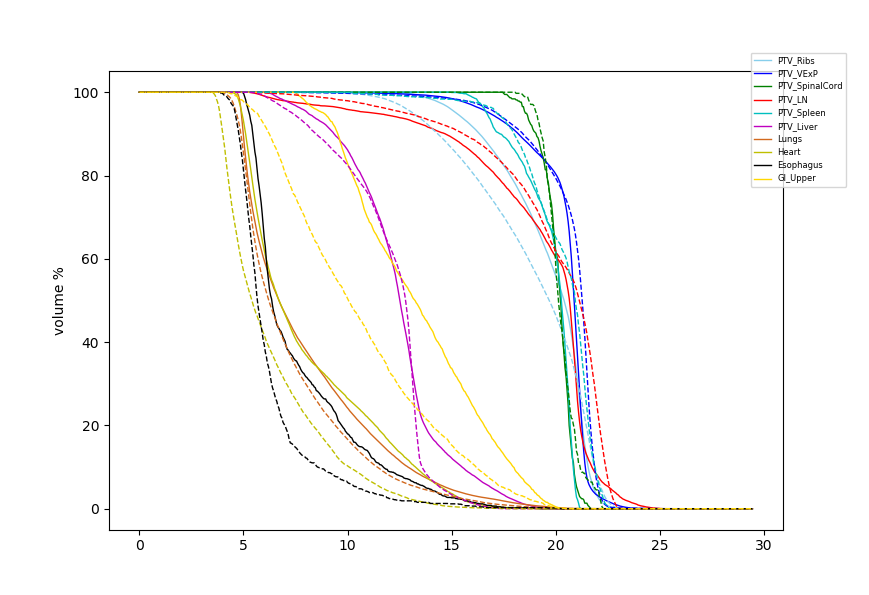

In [11]:
f = loadmat('Data_v4/test/data_LARASH_NEW.mat')
structure = f['structset_2d_channel']
dose_true = f['doseset_2d']
dose_true = np.expand_dims(dose_true,axis=3)
structure = np.array(structure, dtype='float32')
dose_true = np.array(dose_true).astype('float32')
mask = structure>0
mask_Body = np.squeeze(mask[:,:,:,0])
mask_Body = np.expand_dims(mask_Body,axis=3)
#dose_true = np.multiply(dose_true, mask_Body)
mask_Lung = np.squeeze(mask[:,:,:,7])


dose_predict = np.zeros(dose_true.shape)
dose_diff = np.zeros(dose_true.shape)
for i in range(0,dose_true.shape[0]):
    structure_plane = np.expand_dims(structure[i,:,:,:],axis=0)
    dose_plane = model.predict(structure_plane)
    dose_predict[i,:,:,:]=dose_plane
dose_diff = np.add(np.multiply(-1,dose_true),dose_predict)

print("the MSE before dose normalization to lung is", mse(dose_true, dose_predict))

mask_Lung = mask_Lung.flatten()
dose_flat = dose_true.flatten()
dose_masked =  np.ma.masked_where(mask_Lung==False, dose_flat)
dose_true_Lung = dose_masked.compressed()
dose_true = dose_true/dose_Lung_true.mean()*8.0

dose_flat = dose_true.flatten()
mask_organ = mask_Lung.flatten()
dose_masked =  np.ma.masked_where(mask_organ==False, dose_flat)
dose_organ = dose_masked.compressed()
print('true lung dose mean', dose_organ.mean())


dose_flat = dose_predict.flatten()
dose_masked =  np.ma.masked_where(mask_Lung==False, dose_flat)
dose_predict_Lung = dose_masked.compressed()
#dose_predict = dose_predict/dose_Lung_predict.mean()*8.0

print("the MSE after dose normalization to lung is", mse(dose_true, dose_predict))


organ_all = [1,2,3,4,5,6,7,8,9,10]
organ_name = ['PTV_Ribs','PTV_VExP','PTV_SpinalCord','PTV_LN','PTV_Spleen','PTV_Liver','Lungs','Heart','Esophagus','GI_Upper']
organ_number = 10
organ_true_mean = np.zeros(organ_number)
organ_true_max = np.zeros(organ_number)
D95_true = np.zeros(organ_number)
D5_true = np.zeros(organ_number)
D98_true = np.zeros(organ_number)
D2_true = np.zeros(organ_number)


organ_predict_mean = np.zeros(organ_number)
organ_predict_max = np.zeros(organ_number)
D95_predict = np.zeros(organ_number)
D5_predict = np.zeros(organ_number)
D98_predict = np.zeros(organ_number)
D2_predict = np.zeros(organ_number)

DVH_inv = 0.05
DVH_bin = int(29/DVH_inv+10)
DVH_true_all = np.zeros([organ_number,DVH_bin])
DVH_predict_all = np.zeros([organ_number,DVH_bin])
dose_bin = np.zeros(DVH_bin)
dose_bin = np.arange(0,DVH_bin)*DVH_inv
dose_bin1 = np.arange(-1,DVH_bin)*DVH_inv

for organ in organ_all:
    dose_flat = dose_true.flatten()
    dose_flat_predict = dose_predict.flatten()
    mask = structure>0
    mask_organ = np.squeeze(mask[:,:,:,organ])
    mask_organ = mask_organ.flatten()
    volume = len(mask_organ==True)
    dose_masked =  np.ma.masked_where(mask_organ==False, dose_flat)
    dose_organ = dose_masked.compressed()
    organ_true_mean[organ-1] = dose_organ.mean()
    organ_true_max[organ-1] = dose_organ.max()
    
    dose_masked =  np.ma.masked_where(mask_organ==False, dose_flat_predict)
    dose_organ_predict = dose_masked.compressed()
    organ_predict_mean[organ-1] = dose_organ_predict.mean()
    organ_predict_max[organ-1] = dose_organ_predict.max()
    
    DVH_true = np.zeros(DVH_bin)
    DVH_predict = np.zeros(DVH_bin)
    
    DVH, bin_edges = np.histogram(dose_organ,dose_bin1)
    DVH_true = np.cumsum(DVH)
    DVH_true = 1 - DVH_true/DVH_true.max()
    
    DVH, bin_edges =  np.histogram(dose_organ_predict,dose_bin1)
    DVH_predict = np.cumsum(DVH)
    DVH_predict = 1-DVH_predict/DVH_predict.max()
    
    index = np.argmin(np.abs(DVH_true-0.95))
    D95_true[organ-1] = index*DVH_inv
    index = np.argmin(np.abs(DVH_predict-0.95))
    D95_predict[organ-1] = index*DVH_inv
    
    index = np.argmin(np.abs(DVH_true-0.98))
    D98_true[organ-1] = index*DVH_inv
    index = np.argmin(np.abs(DVH_predict-0.98))
    D98_predict[organ-1] = index*DVH_inv
    
    index = np.argmin(np.abs(DVH_true-0.05))
    D5_true[organ-1] = index*DVH_inv
    index = np.argmin(np.abs(DVH_predict-0.05))
    D5_predict[organ-1] = index*DVH_inv
    
    index = np.argmin(np.abs(DVH_true-0.02))
    D2_true[organ-1] = index*DVH_inv
    index = np.argmin(np.abs(DVH_predict-0.02))
    D2_predict[organ-1] = index*DVH_inv
        
    DVH_true_all[organ-1,:] = DVH_true
    DVH_predict_all[organ-1,:]=DVH_predict
    
    DVH_true_all[organ-1,:] = DVH_true
    DVH_predict_all[organ-1,:] = DVH_predict
    
    
    
    print('True mean organ dose is: ', dose_organ.mean())
    print('Predict mean organ dose is: ', dose_organ_predict.mean())
    print('the dose difference is:', '{:.2%}'.format((dose_organ_predict.mean()-dose_organ.mean())/20))
    print('True max organ dose is: ', dose_organ.max())
    print('Predict max organ dose is: ', dose_organ_predict.max())
    print('the dose difference is:', '{:.2%}'.format((dose_organ_predict.max()-dose_organ.max())/20))

    
fig = plt.figure()
plt.plot(dose_bin,DVH_true_all[0,:]*100, color='skyblue', linewidth=1)
plt.plot(dose_bin,DVH_true_all[1,:]*100, color='b', linewidth=1)
plt.plot(dose_bin,DVH_true_all[2,:]*100, color='g', linewidth=1)
plt.plot(dose_bin,DVH_true_all[3,:]*100, color='r', linewidth=1)
plt.plot(dose_bin,DVH_true_all[4,:]*100, color='c', linewidth=1)
plt.plot(dose_bin,DVH_true_all[5,:]*100, color='m', linewidth=1)
plt.plot(dose_bin,DVH_true_all[6,:]*100, color='chocolate', linewidth=1)
plt.plot(dose_bin,DVH_true_all[7,:]*100, color='y', linewidth=1)
plt.plot(dose_bin,DVH_true_all[8,:]*100, color='k', linewidth=1)
plt.plot(dose_bin,DVH_true_all[9,:]*100, color='gold', linewidth=1)


plt.plot(dose_bin,DVH_predict_all[0,:]*100, color='skyblue', linewidth=1, linestyle='dashed')
plt.plot(dose_bin,DVH_predict_all[1,:]*100, color='b', linewidth=1, linestyle='dashed')
plt.plot(dose_bin,DVH_predict_all[2,:]*100, color='g', linewidth=1, linestyle='dashed')
plt.plot(dose_bin,DVH_predict_all[3,:]*100, color='r', linewidth=1, linestyle='dashed')
plt.plot(dose_bin,DVH_predict_all[4,:]*100, color='c', linewidth=1, linestyle='dashed')
plt.plot(dose_bin,DVH_predict_all[5,:]*100, color='m', linewidth=1, linestyle='dashed')
plt.plot(dose_bin,DVH_predict_all[6,:]*100, color='chocolate', linewidth=1,linestyle='dashed')
plt.plot(dose_bin,DVH_predict_all[7,:]*100, color='y', linewidth=1, linestyle='dashed')
plt.plot(dose_bin,DVH_predict_all[8,:]*100, color='k', linewidth=1, linestyle='dashed')
plt.plot(dose_bin,DVH_predict_all[9,:]*100, color='gold', linewidth=1, linestyle='dashed')


plt.ylabel('volume %')


plt.legend(['PTV_Ribs','PTV_VExP','PTV_SpinalCord','PTV_LN','PTV_Spleen','PTV_Liver','Lungs','Heart','Esophagus','GI_Upper'], loc='upper right',bbox_to_anchor=(1.1, 1.05),prop={'size': 6}) 
plt.show()



In [14]:
index = 0;
np.save('Data_v4/test/data_LARASH_predict.npy', dose_predict)
Dmean_true_all[index,:] = organ_true_mean
Dmean_predict_all[index,:] = organ_predict_mean
Dmean_diff_all[index,:] = abs(np.divide((organ_predict_mean-organ_true_mean), organ_true_mean))
print('Dmean diff ',Dmean_diff_all[index,:]*100)

Dmax_true_all[index,:] = organ_true_max
Dmax_predict_all[index,:] = organ_predict_max
Dmax_diff_all[index,:] = abs(np.divide((organ_predict_max-organ_true_max), organ_true_max))
print('Dmax diff ',Dmax_diff_all[index,:]*100)

D95_true_all[index,:] = D95_true
D95_predict_all[index,:] = D95_predict
D95_diff_all[index,:] = abs(np.divide((D95_predict-D95_true), D95_true))
print('D95 diff ',D95_diff_all[index,:]*100)

D5_true_all[index,:] = D5_true
D5_predict_all[index,:] = D5_predict
D5_diff_all[index,:] = abs(np.divide((D5_predict-D5_true), D5_true))
print('D5 diff ',D5_diff_all[index,:]*100)

D98_true_all[index,:] = D98_true
D98_predict_all[index,:] = D98_predict
D98_diff_all[index,:] = abs(np.divide((D98_predict-D98_true), D98_true))
print('D98 diff ',D98_diff_all[index,:]*100)

D2_true_all[index,:] = D2_true
D2_predict_all[index,:] = D2_predict
D2_diff_all[index,:] = abs(np.divide((D2_predict-D2_true), D2_true))
print('D2 diff ',D2_diff_all[index,:]*100)

Dmean diff  [ 3.19363395  2.17358988  3.6736129   3.93560287  2.75198457  4.34545644
  7.01899015 10.10354851 13.61327439 21.05861022]
Dmax diff  [ 2.67529793  5.84066161  3.53990991  2.75384835 10.17986654  0.18498481
  1.30956065  4.81356028 10.78807062 10.84367293]
D95 diff  [11.51315789  3.57142857  7.27762803 25.77777778  1.49700599 19.13580247
  6.12244898 10.1010101  15.23809524 35.59322034]
D5 diff  [ 2.98165138  3.4562212   5.23809524  0.66371681  8.35322196  9.14454277
 11.48648649 13.05841924 21.37681159  0.        ]
D98 diff  [13.02816901  4.87012987  7.96703297 75.36231884  3.07692308 13.57142857
  7.29166667 10.52631579 16.66666667 32.0754717 ]
D2 diff  [ 2.70880361  1.33928571  4.21545667  2.99145299  9.02612827  6.64819945
 12.39193084  7.69230769 20.83333333  6.70103093]


In [25]:
np.savez('Data_v3/test/DVH_parameter_GAN_true.npz', Dmean_true_all, Dmax_true_all, D95_true_all, D5_true_all, D98_true_all, D2_true_all)
np.savez('Data_v3/test/DVH_parameter_GAN_predict.npz', Dmean_predict_all, Dmax_predict_all, D95_predict_all, D5_predict_all, D98_predict_all, D2_predict_all)
np.savez('Data_v3/test/DVH_parameter_GAN_diff.npz', Dmean_diff_all, Dmax_diff_all, D95_diff_all, D5_diff_all, D98_diff_all, D2_diff_all)


In [15]:
for i in range(10):
    print ('the organ',organ_name[i],'mean diff is', np.mean(Dmean_diff_all[0:3,i])*100)
    print ('the organ',organ_name[i],'mean diff std', np.std(Dmean_diff_all[0:3,i])*100)
    print ('the organ',organ_name[i],'max diff is', np.mean(Dmax_diff_all[0:3,i])*100)
    print ('the organ',organ_name[i],'max diff is std', np.std(Dmax_diff_all[0:3,i])*100)
    print ('the organ',organ_name[i],'D95 diff is', np.mean(D95_diff_all[0:3,i])*100)
    print ('the organ',organ_name[i],'D95 diff is std', np.std(D95_diff_all[0:3,i])*100)
    print ('the organ',organ_name[i],'D5 diff is', np.mean(D5_diff_all[0:3,i])*100)
    print ('the organ',organ_name[i],'D5 diff is std', np.std(D5_diff_all[0:3,i])*100)
    print ('the organ',organ_name[i],'D98 diff is', np.mean(D98_diff_all[0:3,i])*100)
    print ('the organ',organ_name[i],'D98 diff is std', np.std(D98_diff_all[0:3,i])*100)

the organ PTV_Ribs mean diff is 1.0645446486083192
the organ PTV_Ribs mean diff std 1.505493479813586
the organ PTV_Ribs max diff is 0.8917659763299541
the organ PTV_Ribs max diff is std 1.2611475381887056
the organ PTV_Ribs D95 diff is 3.8377192982456143
the organ PTV_Ribs D95 diff is std 5.427354680159904
the organ PTV_Ribs D5 diff is 0.9938837920489327
the organ PTV_Ribs D5 diff is std 1.4055639381384015
the organ PTV_Ribs D98 diff is 4.342723004694834
the organ PTV_Ribs D98 diff is std 6.141537770869073
the organ PTV_VExP mean diff is 0.7245299588637056
the organ PTV_VExP mean diff std 1.0246400941706733
the organ PTV_VExP max diff is 1.9468872017590801
the organ PTV_VExP max diff is std 2.7533142851382952
the organ PTV_VExP D95 diff is 1.1904761904761931
the organ PTV_VExP D95 diff is std 1.6835875742536885
the organ PTV_VExP D5 diff is 1.152073732718894
the organ PTV_VExP D5 diff is std 1.6292782976648559
the organ PTV_VExP D98 diff is 1.6233766233766271
the organ PTV_VExP D98 di

In [12]:
print(organ_name)
print(D5_true)
print(D5_predict)

['PTV_Ribs', 'PTV_VExP', 'PTV_SpinalCord', 'PTV_LN', 'PTV_Spleen', 'PTV_Liver', 'Lungs', 'Heart', 'Esophagus', 'GI_Upper']
[22.55 22.55 22.   22.7  23.45 14.65 14.   14.6  11.7  21.45]
[22.5  22.35 22.1  22.4  23.45 15.   14.3  15.25 11.65 22.35]


In [36]:
np.save('Data_v2/validation/data_Colon_predict.npy', dose_predict)